# KAIROS valuation of iNaturalist subset using clean insect data

https://github.com/lodino/kairos/blob/main/examples/image-data.ipynb 

#### TODO
- Currently just transferred code from Q1 experiments on adult income dataset. Will adapt for the clean insect data (validation) and iNaturalist dataset (training/messy).
- Make output the top X highest valued images from the inaturalist dataset (only the insects as theoretically labeled by humans) to use for finetuning ResNet-50.

Collecting "noisy" indexes: if label is not one of the species in our main insect categories, it is noisy. We might create a semi-noisy label for images that are insects but are just not ones we are looking for. Since the method could value them as "clean" and it wouldn't be totally wrong, we just want to know how accurate Kairos is being.

In [1]:
import sys
sys.path.append('../')

import opendataval
from opendataval.experiment import ExperimentMediator
from opendataval.dataval.api import DataEvaluator, ModelLessMixin
from opendataval.dataval import DataOob, LavaEvaluator, DVRL
from opendataval.experiment import discover_corrupted_sample, noisy_detection
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.model import ClassifierMLP, LogisticRegression

import matplotlib.pyplot as plt
import numpy as np
import torch
import json
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


import utils.custom_valuations
from utils.utils import *

import importlib
importlib.reload(utils.custom_valuations)
importlib.reload(utils)

from utils.custom_valuations import *
from utils import *
#from fixed_valuations import *

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.mixture import GaussianMixture

PATH_TO_DATA="data_files" #change based on working directory

markers = {
    'DataOob': 'o',
    'KNNShapley': 's',
    'FixedKNNShapley': 's',
    'FixedLavaEvaluator': 'x',
    #'LavaEvaluator': 'x',
    'DVRL': 'x',
    'Kairos': '^',
}

def write_dict(d, fname):
    txt = json.dumps(d)
    with open(f'logs/{fname}.json', 'w+') as f:
        f.write(txt)
        
train_count, valid_count, test_count = ...,...,...
train_kwargs = {"epochs": 3, "batch_size": 100, "lr": 0.01}
metric_name = 'accuracy'

/home/mgaddi/.conda/envs/kairos/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
# check embedding files are as expected before moving forward
print(np.load("data/embs/inat_labels.npy").shape)
print(np.load("data/embs/kairos_clean_labels.npy").shape)
print(np.load("data/embs/inat_embeddings.npy").shape)
print(np.load("data/embs/kairos_clean_embeddings.npy").shape)

(36355,)
(450,)
(36355, 512)
(450, 512)


In [3]:
# import matplotlib.pyplot as plt
# plt.hist(np.load("data/embs/inat_clean_indexes.npy"), bins=30)

In [4]:
# encode labels from strings to numberic ids so Kairos can process them
def encode_labels(train_labels, valid_labels):
    all_labels = np.unique(np.concatenate([train_labels, valid_labels]))
    all_labels = np.unique(np.concatenate([train_labels, valid_labels]))
    num_classes = len(all_labels)
    label2id = {label: i for i, label in enumerate(all_labels)}
    id2label = {i: label for label, i in label2id.items()}

    train_ids = np.array([label2id[l] for l in train_labels], dtype=np.int64)
    valid_ids = np.array([label2id[l] for l in valid_labels], dtype=np.int64)

    return train_ids, valid_ids, label2id, id2label, num_classes


def load_inat_data(): 
    train_labels = np.load("data/embs/inat_labels.npy")
    valid_labels = np.load("data/embs/kairos_clean_labels.npy")

    

    train_ids, valid_ids, label2id, id2label, num_classes = encode_labels(
        train_labels, valid_labels
    )
    
    # 1. Set training set.
    x_train = np.load("data/embs/inat_embeddings.npy")[:20000]
    x_valid = np.load("data/embs/kairos_clean_embeddings.npy")
    
    y_train = np.array([label2id[l] for l in train_labels], dtype=int)[:20000]
    y_valid = np.array([label2id[l] for l in valid_labels], dtype=int)

    print(x_train.shape, x_valid.shape)
    print(y_train.shape, y_valid.shape)

    # set dummy test set so Kairos runs
    x_test = x_valid[:1]
    y_test = y_valid[:1]

    
    # One-hot encode
    y_train = np.eye(num_classes)[y_train]
    y_valid = np.eye(num_classes)[y_valid]
    y_test  = np.eye(num_classes)[y_test]

    # print('shape')
    # print(y_train.shape, y_valid.shape)

    # print(np.unique(y_valid))
    # print(np.unique(y_train))
    
    covariates = (x_train, x_valid, x_test)
    labels = (y_train, y_valid, y_test)

    return covariates, labels



Register(
        dataset_name=f"iNat",
        one_hot=False,
        cacheable=False,
        presplit=True
    )(lambda: load_inat_data())

fetcher = DataFetcher("iNat")

(20000, 512) (450, 512)
(20000,) (450,)


In [8]:
# Estimate kernel bandwidth w/ median sample pairwise distance
kairos = Kairos()
kairos.input_data(fetcher.x_train, fetcher.y_train, fetcher.x_valid, fetcher.y_valid)
sigma_feature = max(est_median_dist(kairos.X_valid.numpy()), est_median_dist(kairos.X_train.numpy()))

#fetcher.noisy_train_indices = np.load("data/embs/inat_noisy_indexes.npy")
fetcher.noisy_train_indices = [i for i in np.load("data/embs/inat_noisy_indexes.npy") if i < 20000] # indexes are not sorted

Elapsed time Kairos(sigma_feature=0.8511463403701782): 0:00:03.657377


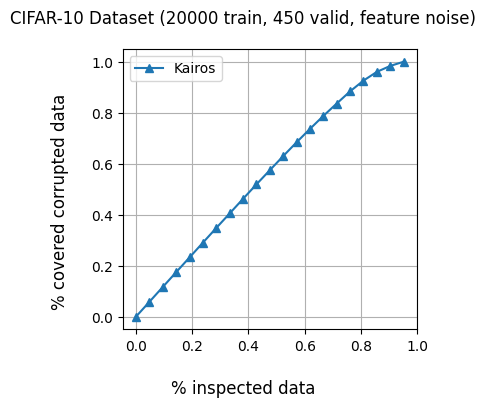

In [9]:
# this cell breaks and restarts kernel. Dataset too large. 28k works, 30k too big
model_name = LogisticRegression(input_dim=len(fetcher.x_train[0]), num_classes=len(fetcher.y_train[0]))
exper_med = ExperimentMediator(fetcher=fetcher, pred_model=model_name, train_kwargs=train_kwargs,
                               metric_name=metric_name, raises_error=True)

fig = plt.figure(figsize=(4, 4))
list_of_data_evaluators = [
    #FixedKNNShapley(),
    #DataOob(num_models=10), LavaEvaluator(random_state=42),
    Kairos(sigma_feature=sigma_feature),
]
eval_med = exper_med.compute_data_values(list_of_data_evaluators)
all_d = dict()
for evaluator in eval_med.data_evaluators:
    d = get_discover_corrupted_sample_results(evaluator, fetcher)
    eval_name = evaluator.__class__.__name__
    all_d[eval_name] = d
    plt.plot(d['axis'], d['corrupt_found'], marker=markers[eval_name], label=eval_name)
plt.grid()
plt.legend()
for ax in fig.axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.supylabel('% covered corrupted data')
fig.supxlabel('% inspected data')
fig.suptitle(f'CIFAR-10 Dataset ({len(fetcher.x_train)} train, {len(fetcher.x_valid)} valid, feature noise)')
plt.tight_layout()

# if noisy indexes is truncated at 20k while inat data is truncated at 28k, % covered corrupted data can get to 1.0, 
#but if they are noth 20k or both 28k it stops around .8

2895 17105


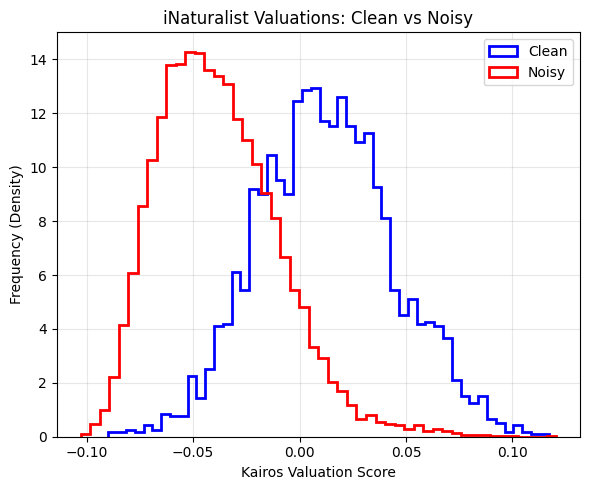

In [11]:
evalu = None
for evaluator in eval_med.data_evaluators:
        if evaluator.__class__.__name__ == eval_name:
                evalu = evaluator
                break

if evalu is None:
        raise RuntimeError(f"{eval_name} evaluator not found in eval_med")

valuations = evalu.data_values

# Identify noisy vs clean indices
noisy_idxs = np.array(fetcher.noisy_train_indices)
clean_idxs = np.setdiff1d(np.arange(len(valuations)), noisy_idxs)

vals_noisy = valuations[noisy_idxs]
vals_clean = valuations[clean_idxs]
print(len(vals_clean), len(vals_noisy))

plt.figure(figsize=(6,5))

# Histogram curves 
plt.hist(vals_clean, bins=50, density=True, histtype='step', linewidth=2, label="Clean", color='blue')
plt.hist(vals_noisy, bins=50, density=True, histtype='step', linewidth=2, label="Noisy", color='red')

# KDE smooth curves 
# from scipy.stats import gaussian_kde
# xs = np.linspace(min(valuations), max(valuations), 500)
# plt.plot(xs, gaussian_kde(vals_clean)(xs), label="Clean KDE", color='blue')
# plt.plot(xs, gaussian_kde(vals_noisy)(xs), label="Noisy KDE", color='red')

plt.xlabel(f"Kairos Valuation Score")
plt.ylabel("Frequency (Density)")
plt.title(f"iNaturalist Valuations: Clean vs Noisy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
### plot accuracy
def plot_valuations(eval_name, eval_med, fetcher, dataset_name, exp_num):

    evalu = None
    for evaluator in eval_med.data_evaluators:
            if evaluator.__class__.__name__ == eval_name:
                    evalu = evaluator
                    break

    if evalu is None:
            raise RuntimeError(f"{eval_name} evaluator not found in eval_med")

    valuations = evalu.data_values  # length = n_train

    # Identify noisy vs clean indices
    noisy_idxs = np.array(fetcher.noisy_train_indices)
    clean_idxs = np.setdiff1d(np.arange(len(valuations)), noisy)

    vals_noisy = valuations[noisy_idxs]
    vals_clean = valuations[clean_idxs]
    print(len(vals_clean), len(vals_noisy))

    plt.figure(figsize=(6,5))

    # Histogram curves 
    plt.hist(vals_clean, bins=50, density=True, histtype='step', linewidth=2, label="Clean", color='blue')
    plt.hist(vals_noisy, bins=50, density=True, histtype='step', linewidth=2, label="Noisy", color='red')

    # KDE smooth curves 
    # from scipy.stats import gaussian_kde
    # xs = np.linspace(min(valuations), max(valuations), 500)
    # plt.plot(xs, gaussian_kde(vals_clean)(xs), label="Clean KDE", color='blue')
    # plt.plot(xs, gaussian_kde(vals_noisy)(xs), label="Noisy KDE", color='red')

    plt.xlabel(f"{eval_name} Valuation Score")
    plt.ylabel("Frequency (Density)")
    plt.title(f"{eval_name} {dataset_name} Valuations: Clean vs Noisy (Exp {exp_num})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def thresh_acc(eval_name, eval_med, dataset_name, exp_num, fetcher):
    evalu = None
    for evaluator in eval_med.data_evaluators:
        if evaluator.__class__.__name__ == eval_name:
            evalu = evaluator
            break

    if evalu is None:
        raise RuntimeError(f"{eval_name} evaluator not found in eval_med")

    valuations = evalu.data_values
    
    vals = valuations.reshape(-1,1)
    gmm = GaussianMixture(n_components=2, random_state=42).fit(vals)

    # responsibilities: P(component k | v_i)
    probs = gmm.predict_proba(vals)

    # Determine which component = noisy (lower mean)
    means = gmm.means_.reshape(-1)
    noisy_component = np.argmin(means)  

    # threshold = decision boundary between gaussians
    threshold = np.mean([
        means[noisy_component],
        means[1-noisy_component]
    ])
    
    print(f"{eval_name} {dataset_name} experiment {exp_num}")
    print("GMM threshold:", round(threshold, 4))

    pred = (valuations < threshold).astype(int)  

    y_true = np.zeros(len(valuations), dtype=int)
    y_true[fetcher.noisy_train_indices] = 1  # 1 = real noisy

    accuracy = round((pred == y_true).mean(), 4)

    from sklearn.metrics import precision_score, recall_score, f1_score

    precision = round(precision_score(y_true, pred), 4)
    recall = round(recall_score(y_true, pred), 4)
    f1 = round(f1_score(y_true, pred), 4)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print('----------------------------------')

In [ ]:
def run_experiment(dataset_name, exp_num, data_frac, path_to_data):

    Register(
        dataset_name=f"{dataset_name}_experiment{exp_num}",
        one_hot=False,
        cacheable=False,
        presplit=True
    )(lambda: load_presplit_dataset(dataset_name, exp_num, data_frac, path_to_data))#(load_presplit_dataset(dataset_name, exp_num, data_frac, path_to_data))

    fetcher = DataFetcher(f"{dataset_name}_experiment{exp_num}")
    fetcher.noisy_train_indices = [i for i in noisy_indexes[f"exp{exp_num}"] if i < len(fetcher.x_train)]
    curr_noisy_idxs = sum(np.array(fetcher.noisy_train_indices) < len(fetcher.x_train))

    # Estimate kernel bandwidth w/ median sample pairwise distance
    kairos = Kairos()
    kairos.input_data(fetcher.x_train, fetcher.y_train, fetcher.x_valid, fetcher.y_valid)
    sigma_feature = max(est_median_dist(kairos.X_valid.numpy()), est_median_dist(kairos.X_train.numpy()))

    ### plot Covered vs Inspected data
    model_name = LogisticRegression(input_dim=len(fetcher.x_train[0]), num_classes=(int(np.max(fetcher.y_train)) + 1)) #Used to be fetcher.y_train[0].size
    exper_med = ExperimentMediator(fetcher=fetcher, pred_model=model_name, train_kwargs=train_kwargs,
                                metric_name=metric_name, raises_error=True)

    fig = plt.figure(figsize=(4, 4))
    list_of_data_evaluators = [
        FixedKNNShapley(),
        DataOob(num_models=10),
        #LavaEvaluator(random_state=42), #breaks if dataset too big
        Kairos(sigma_feature=sigma_feature, lambda_weight=.97),
    ]
    eval_med = exper_med.compute_data_values(list_of_data_evaluators)

    for evaluator in eval_med.data_evaluators:
        d = get_discover_corrupted_sample_results(evaluator, fetcher)
        eval_name = evaluator.__class__.__name__
        plt.plot(d['axis'], d['corrupt_found'], marker=markers[eval_name], label=eval_name)
    plt.grid()
    plt.legend()
    for ax in fig.axes:
        ax.set_ylabel('')
        ax.set_xlabel('')
    fig.supylabel('% covered corrupted data')
    fig.supxlabel('% inspected data')
    fig.suptitle(f'Kairos: {dataset_name} ({len(fetcher.x_train)} train, {len(fetcher.x_valid)} valid, {curr_noisy_idxs} label noise) Exp 2')
    plt.tight_layout()


    plot_valuations("Kairos", eval_med, fetcher, dataset_name, exp_num)

    thresh_acc("Kairos", eval_med, dataset_name, exp_num, fetcher)


In [ ]:
run_experiment(dataset_name="adult", exp_num=2, data_frac=0.35, path_to_data=PATH_TO_DATA)